# **Классификация с помощью логистической регрессии**

**Выполнил студент ФИО**

# 1.Выберете набор данных для Классификации

Выполните импорт данных. Оцените типы имеющихся данных, проверьте наличие дубликатов и/или пропущенных значений.

* Import библиотек

In [54]:
import pandas as pd # Библиотека Pandas для работы с табличными данными
import numpy as np # библиотека Numpy для операций линейной алгебры и прочего
import matplotlib.pyplot as plt # библиотека MatPlotLib для визуализации
import seaborn as sns; sns.set() # библиотека Seaborn для визуализации данных из Pandas

from sklearn.model_selection import train_test_split #  функция разбиения на тренировочную и тестовую выборку
# но в исполнении scikit-learn
from sklearn.impute import SimpleImputer # Объект для замены пропущенных значений
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler # Импортируем нормализацию и One-Hot Encoding от scikit-learn
from sklearn import preprocessing as prep  # общий модуль предварительной обработки scikit-learn
from sklearn import set_config # для доп настроек

from sklearn.pipeline import Pipeline # Pipeline - суперпомощник автоматизации обработки данных
from sklearn.compose import ColumnTransformer # т.н. преобразователь колонок

from sklearn.model_selection import cross_validate # функция кросс-валидации от Scikit-learn

from sklearn.model_selection import ShuffleSplit # при кросс-валидации случайно перемешиваем данные

from sklearn.metrics import mean_squared_error as mse # метрика MSE от Scikit-learn
from sklearn.metrics import r2_score # коэффициент детерминации  от Scikit-learn


from sklearn.metrics import r2_score, f1_score, mean_squared_error, mean_absolute_error, accuracy_score, recall_score, precision_score, confusion_matrix
from sklearn.linear_model import LogisticRegression # Логистичекая регрессия от scikit-learn
from sklearn.preprocessing import PolynomialFeatures # Объект для генерации полиномиальных признаков от scikit-learn

RANDOM_STATE = 42
import warnings
warnings.filterwarnings('ignore')

* Загрузка и считывание датасета

Ссылка на датасет - https://www.kaggle.com/datasets/jacksondivakarr/car-crash-dataset

In [55]:
df = pd.read_csv("car_crashes.csv", delimiter = ',')
df

,Year,Month,Day,Weekend?,Hour,Collision Type,Injury Type,Primary Factor,Reported_Location,Latitude,Longitude
0,2015,1,5,Weekday,0.0,2-Car,No injury/unknown,OTHER (DRIVER) - EXPLAIN IN NARRATIVE,1ST & FESS,39.159207,-86.525874
1,2015,1,6,Weekday,1500.0,2-Car,No injury/unknown,FOLLOWING TOO CLOSELY,2ND & COLLEGE,39.161440,-86.534848
2,2015,1,6,Weekend,2300.0,2-Car,Non-incapacitating,DISREGARD SIGNAL/REG SIGN,BASSWOOD & BLOOMFIELD,39.149780,-86.568890
3,2015,1,7,Weekend,900.0,2-Car,Non-incapacitating,FAILURE TO YIELD RIGHT OF WAY,GATES & JACOBS,39.165655,-86.575956
4,2015,1,7,Weekend,1100.0,2-Car,No injury/unknown,FAILURE TO YIELD RIGHT OF WAY,W 3RD,39.164848,-86.579625
...,...,...,...,...,...,...,...,...,...,...,...
53938,2003,10,6,Weekday,1700.0,2-Car,No injury/unknown,IMPROPER LANE USAGE,DUNN & WHITE LOT WEST,0.000000,0.000000
53939,2003,11,3,Weekday,800.0,1-Car,No injury/unknown,UNSAFE SPEED,RED OAK & SR446,0.000000,0.000000
53940,2003,12,5,Weekday,1200.0,2-Car,No injury/unknown,BRAKE FAILURE OR DEFECTIVE,2ND ST & WALNUT,0.000000,0.000000
53941,2003,12,1,Weekend,700.0,2-Car,No injury/unknown,UNSAFE BACKING,NINETH & NORTH,0.000000,0.000000


In [56]:
df.info() # информация о данных в датафрейме

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53943 entries, 0 to 53942
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Year               53943 non-null  int64  
 1   Month              53943 non-null  int64  
 2   Day                53943 non-null  int64  
 3   Weekend?           53875 non-null  object 
 4   Hour               53718 non-null  float64
 5   Collision Type     53937 non-null  object 
 6   Injury Type        53943 non-null  object 
 7   Primary Factor     52822 non-null  object 
 8   Reported_Location  53908 non-null  object 
 9   Latitude           53913 non-null  float64
 10  Longitude          53913 non-null  float64
dtypes: float64(3), int64(3), object(5)
memory usage: 4.5+ MB


In [57]:
df = df.dropna(subset=['Year', 'Month', 'Day', 'Weekend?', 'Hour', 'Collision Type', 'Injury Type', 'Primary Factor',
'Reported_Location', 'Latitude', 'Longitude'])  # Удаляем все строки, где есть пустые значения

In [58]:
df = df.drop_duplicates() # удаляем дубликаты
df = df.reset_index(drop=True) # обновим индексы
df.duplicated().sum()

0

## 2. Выполните исследовательский анализ данных.

Оцените связь Признаков с целевой переменной (агрегация с помощью метода groupby библиотеки Pandas).

In [59]:
# делим признаки на котегориальные и числовые

cat_columns = [] # создаем пустой список для имен колонок категориальных данных
num_columns = [] # создаем пустой список для имен колонок числовых данных

for column_name in df.columns: # смотрим на все колонки в датафрейме
    if (df[column_name].dtypes == object): # проверяем тип данных для каждой колонки
        cat_columns +=[column_name] # если тип объект - то складываем в категориальные данные
    else:
        num_columns +=[column_name] # иначе - числовые

# важно: если признак категориальный, но хранится в формате числовых данных, тогда код не сработает корректно


# выводим результат
print('Категориальные данные:\t ',cat_columns, '\n Число столблцов = ',len(cat_columns))

print('Числовые данные:\t ',  num_columns, '\n Число столблцов = ',len(num_columns))


Категориальные данные:	  ['Weekend?', 'Collision Type', 'Injury Type', 'Primary Factor', 'Reported_Location'] 
 Число столблцов =  5
Числовые данные:	  ['Year', 'Month', 'Day', 'Hour', 'Latitude', 'Longitude'] 
 Число столблцов =  6


Удалим зависимые параметры, Age более информативный, поэтому его сгенерируем, а Year удалим.

In [60]:
df['Year'] = 2024 - df['Year']
df.rename(columns = {'Year':'Age'}, inplace = True )
df.head()

,Age,Month,Day,Weekend?,Hour,Collision Type,Injury Type,Primary Factor,Reported_Location,Latitude,Longitude
0,9,1,5,Weekday,0.0,2-Car,No injury/unknown,OTHER (DRIVER) - EXPLAIN IN NARRATIVE,1ST & FESS,39.159207,-86.525874
1,9,1,6,Weekday,1500.0,2-Car,No injury/unknown,FOLLOWING TOO CLOSELY,2ND & COLLEGE,39.161440,-86.534848
2,9,1,6,Weekend,2300.0,2-Car,Non-incapacitating,DISREGARD SIGNAL/REG SIGN,BASSWOOD & BLOOMFIELD,39.149780,-86.568890
3,9,1,7,Weekend,900.0,2-Car,Non-incapacitating,FAILURE TO YIELD RIGHT OF WAY,GATES & JACOBS,39.165655,-86.575956
4,9,1,7,Weekend,1100.0,2-Car,No injury/unknown,FAILURE TO YIELD RIGHT OF WAY,W 3RD,39.164848,-86.579625


Сразу изменим список числовых признаков.

In [61]:
num_columns[0] = 'Age'

In [62]:
num_columns

['Age', 'Month', 'Day', 'Hour', 'Latitude', 'Longitude']

In [63]:
df[cat_columns].nunique()

Weekend?                 2
Collision Type           7
Injury Type              4
Primary Factor          55
Reported_Location    19013
dtype: int64

Выбираем переменную Transmission как целевую.

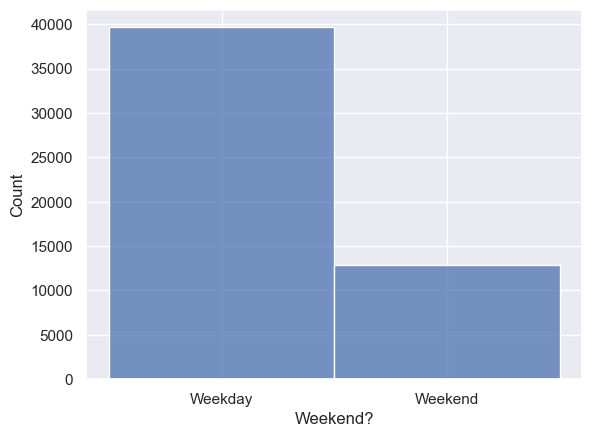

In [64]:
# Посмотрим как выглядит распределение целевой переменной.
target = "Weekend?"
sns.histplot(
    df,
    x=target
)

classification_df=df.copy()

In [65]:
# Группировка по признакам и расчет количества значений целевой переменной
classification_df.groupby('Weekend?').count()

,Age,Month,Day,Hour,Collision Type,Injury Type,Primary Factor,Reported_Location,Latitude,Longitude
Weekend?,,,,,,,,,,
Weekday,39647,39647,39647,39647,39647,39647,39647,39647,39647,39647
Weekend,12873,12873,12873,12873,12873,12873,12873,12873,12873,12873


<Figure size 1000x1000 with 0 Axes>

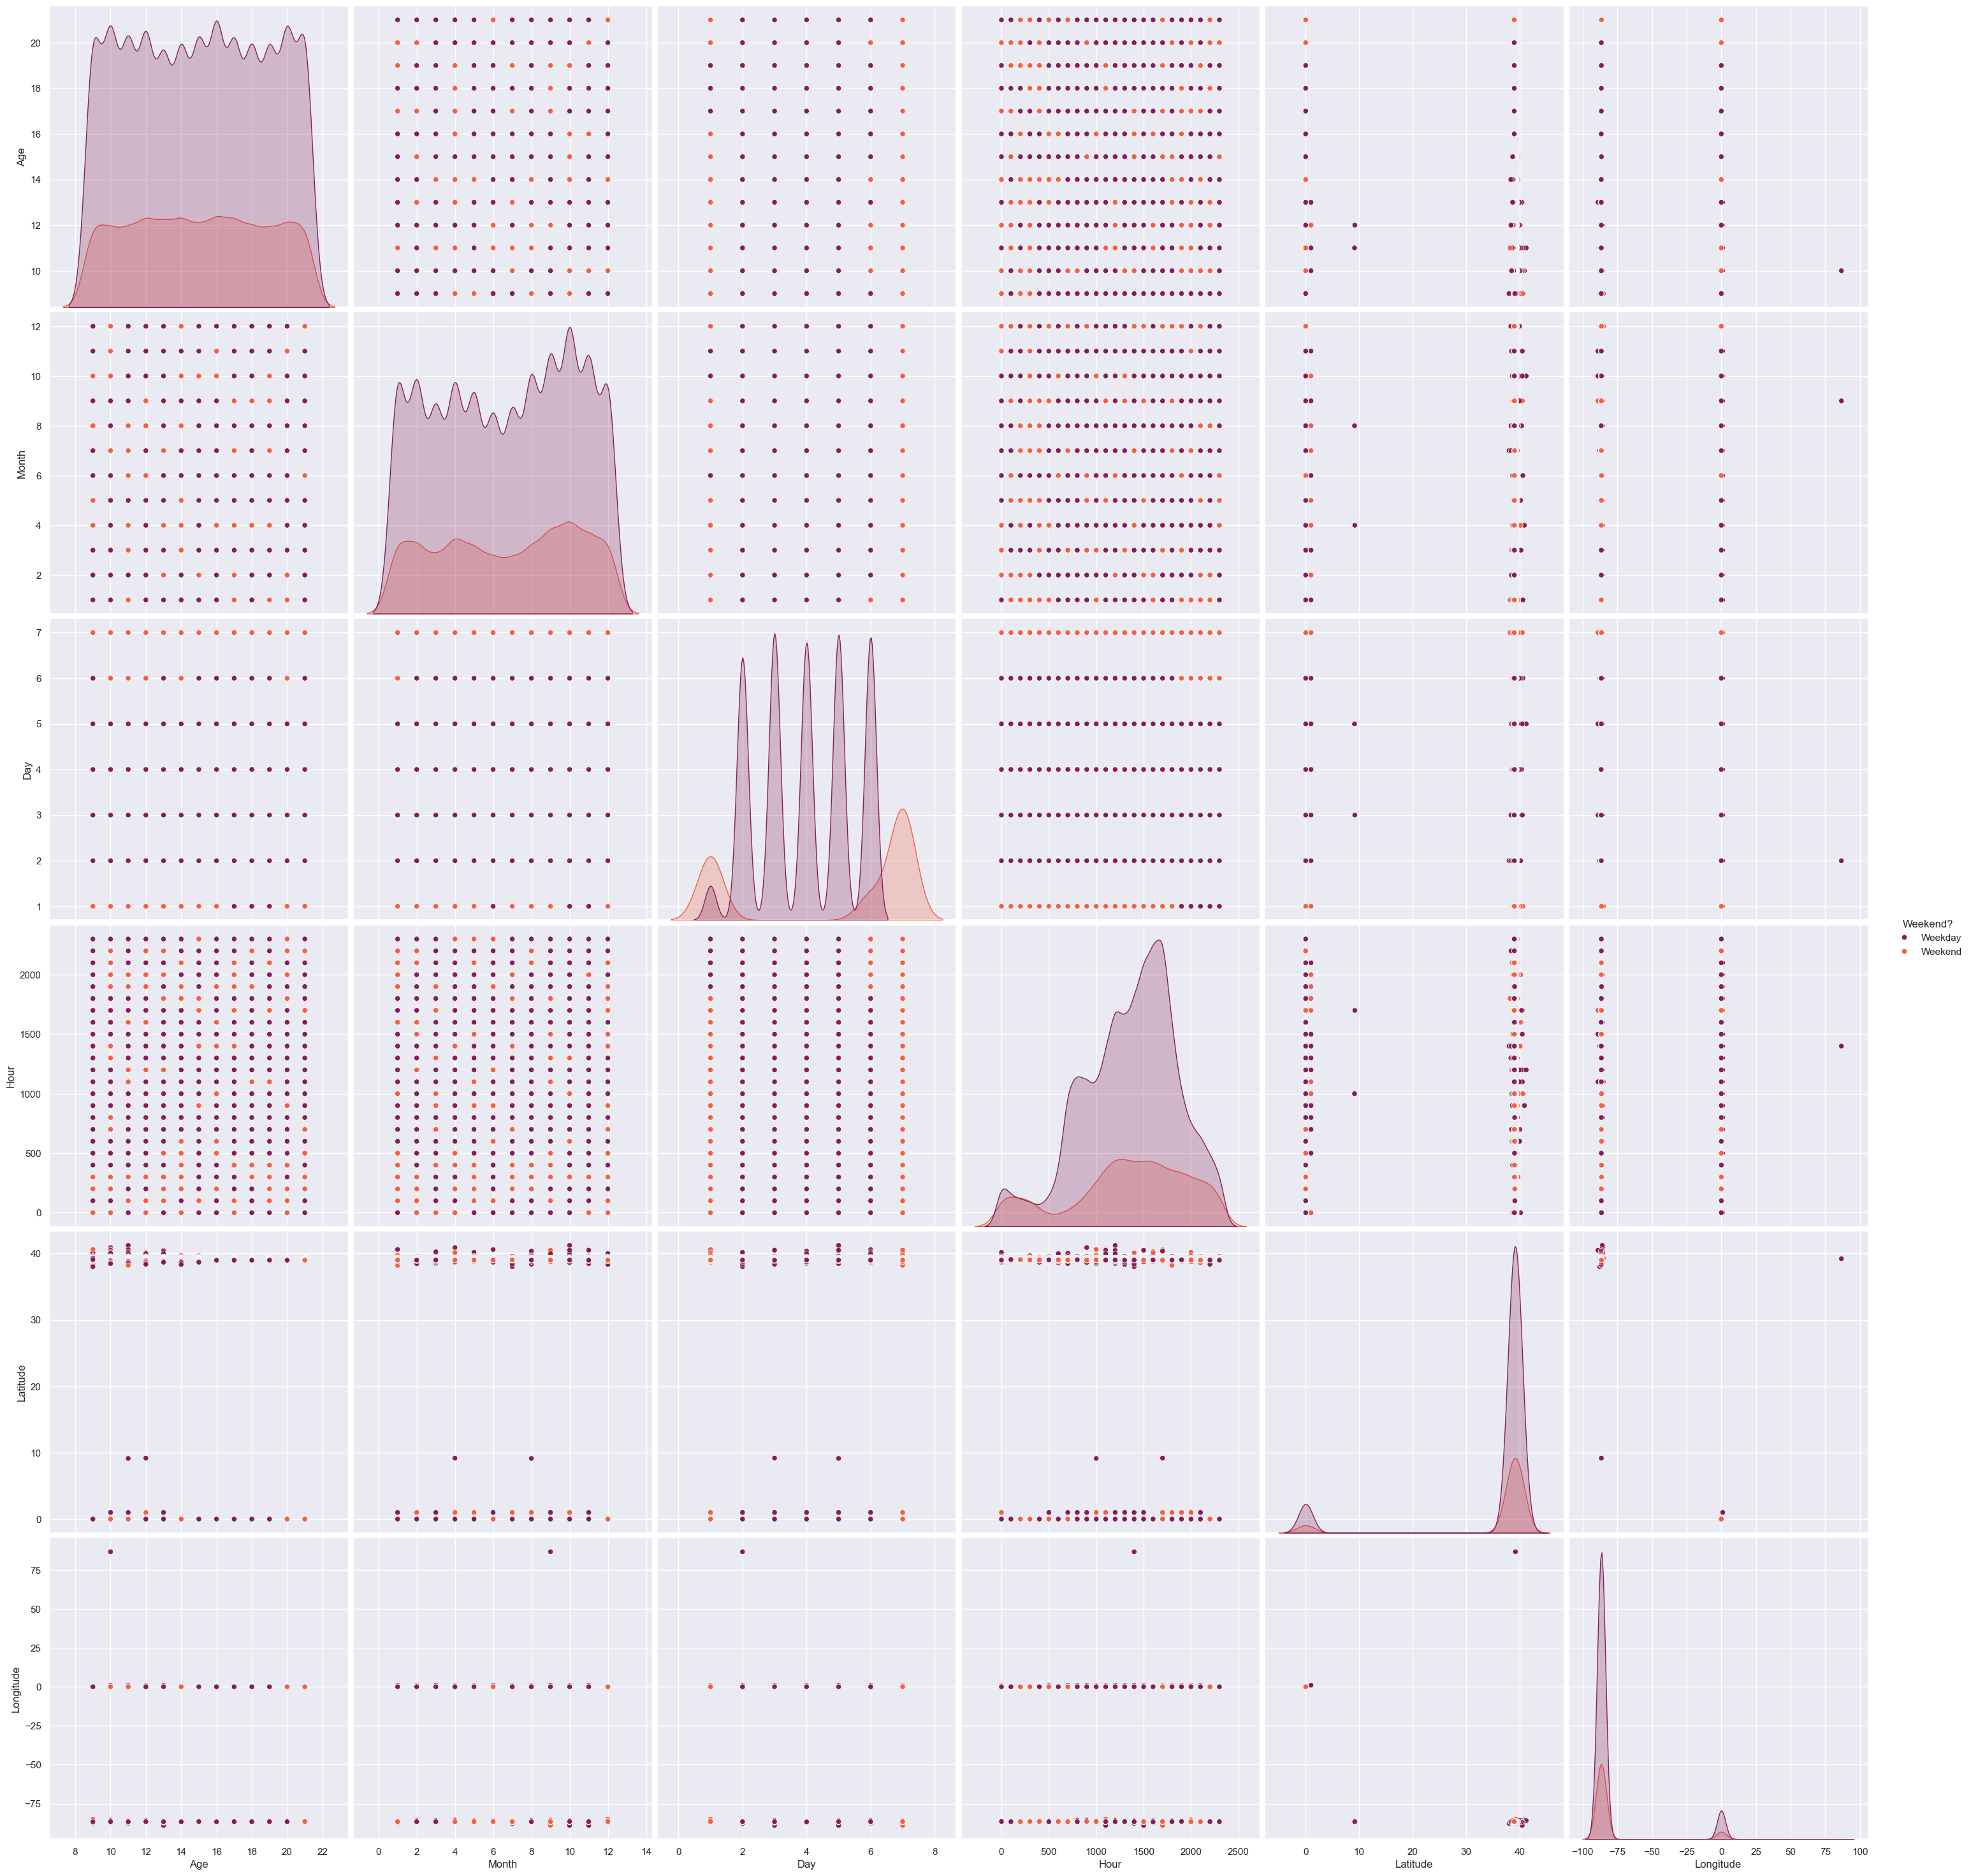

In [66]:
# визуализируем распределение целевой переменной по отношению к числовым признакам
fig = plt.figure(figsize=(10, 10))
sns.pairplot(data = classification_df[['Age', 'Month', 'Day', 'Hour', 'Latitude', 'Longitude', 'Weekend?']],
              hue ='Weekend?',
              palette = 'rocket',
              height=5);

Целевая переменная "Weekday" преобладает в признаках.

# 3.Выполните адекватную предварительную обработку данных

Выполните адекватную предварительную обработку данных разными методами. Разные методы означают стандартизацию, нормализацию и степенное преобразование для числовых признаков и порядковое/one-hot кодирование для категориальных.



* Разделим датасет на признаки и целевые метки

Для задачи классификации выделим признак 'Transmission' в отдельный целевой датасет. Остальные признаки будут данными для тренировки модели.

In [67]:
data = df.drop(columns = ['Weekend?']) # признаках не нужен 'Transmission' - удаляем
target = df['Weekend?'] # поскольку это целевая метка

Сразу скорректируем список категориальных признаков

In [68]:
cat_columns.remove('Weekend?') # уберем Целевую метку из списка категориальных данных


In [69]:
cat_columns

['Collision Type', 'Injury Type', 'Primary Factor', 'Reported_Location']

Приводим целевые метки к 0 и 1 (0 это 'Automatic', а 1 это 'Manual')



In [70]:
Label = prep.LabelEncoder()
Label.fit(target) # задаем столбец, который хотим преобразовать
Label.classes_ # в аттрибуте .classes_ хранится информация "какой класс как шифруется"
Label_encoded = Label.transform(target) # преобразуем и сохраняем в новую переменную
Label_encoded

array([0, 0, 1, ..., 0, 1, 1])

Разбиваем на тестовую и тренировочную выборку.

In [71]:
X_train, X_val, y_train, y_val = train_test_split(data,Label_encoded,
                                                  test_size = 0.2,
                                                  random_state = RANDOM_STATE)

* Выполним нормализацию и порядковое/one-hot кодирование.

* Создаем объект `Pipeline`

На вход ему подаем список из того, что мы хотим объединить в формате:
строка- название (даем имя Объекту)
сам объект (с заданными аргументами, если необходимо)

Сначала создадим отдельно Pipeline для числовых данных

In [72]:
# Pipeline предобработки числовых данных - нормализация
numerical_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),

    ('scaler', MinMaxScaler())

])

In [73]:
numerical_pipe

Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                ('scaler', MinMaxScaler())])

Теперь для категориальных

In [74]:
categorical_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent', )),
    ('encoder', OneHotEncoder(drop='if_binary', handle_unknown='ignore', sparse_output=False))
])

In [75]:
categorical_pipe

Pipeline(steps=[('imputer', SimpleImputer(strategy='most_frequent')),
                ('encoder',
                 OneHotEncoder(drop='if_binary', handle_unknown='ignore',
                               sparse_output=False))])

* Объединяем в единый Трансформер Колонок Данных

Объект `ColumnTransformer` имеет в целом схожий синтаксис с `Pipeline`

т.е. на вход ему также подаем список из того, что мы хотим объединить в формате:

* строка - название (даем имя Объекту)
* сам объект (в этом случае подаем объекты Pipeline)
* добавляется еще список названий столбцов, к которым мы применяем эти преобразования


In [76]:
preprocessors = ColumnTransformer(transformers=[ # передадим пайплайны для объединения в один процесс
    ('num', numerical_pipe, num_columns),
    ('cat', categorical_pipe, cat_columns)
])

In [77]:
preprocessors

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('scaler', MinMaxScaler())]),
                                 ['Age', 'Month', 'Day', 'Hour', 'Latitude',
                                  'Longitude']),
                                ('cat',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('encoder',
                                                  OneHotEncoder(drop='if_binary',
                                                                handle_unknown='ignore',
                                                                sparse_output=False))]),
                                 ['Collision Type', 'Injury Type',
                                  'Primary Factor', 'Reported_Location'])])

# 4.Разделите данные на тренировочную и валидационную выборку.

Разделите данные на тренировочную и валидационную выборку. Определитесь с метриками, по которым вы будете оценивать модель. Учитывайте дисперсию целевой переменной.

Данные на тренировочные и валидационные мы уже разбили. Определимся с метриками.

Создаем функции метрик для оценки модели.

In [78]:
def accuracy(model_pipe, X, y):
  y_model = model_pipe.predict(X)
  return accuracy_score(y, y_model)

def recall(model_pipe, X, y):
  y_model = model_pipe.predict(X)
  return recall_score(y, y_model)

Обучаем стандартно через `.fit()`

Тут важно, что на вход мы подаем датафреймы, т.к. в них есть колонки к которым мы обращаемся по именам. Внимательно следите за названиями колонок, он проверяет всё добуквенно

In [79]:
preprocessors.fit(X_train)

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('scaler', MinMaxScaler())]),
                                 ['Age', 'Month', 'Day', 'Hour', 'Latitude',
                                  'Longitude']),
                                ('cat',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('encoder',
                                                  OneHotEncoder(drop='if_binary',
                                                                handle_unknown='ignore',
                                                                sparse_output=False))]),
                                 ['Collision Type', 'Injury Type',
                                  'Primary Factor', 'Reported_Location'])])

* Проверим, что трансформер колонок работает.

Чисто в тестовых и ознакомительных целях посмотрим на датасет после преобразования.

In [80]:
cat_ohe_names = preprocessors.transformers_[1][1]['encoder'].get_feature_names_out(cat_columns)
cat_ohe_names

array(['Collision Type_1-Car', 'Collision Type_2-Car',
       'Collision Type_3+ Cars', ..., 'Reported_Location_YOST AVE',
       'Reported_Location_ZIKES & ZIKES RD', 'Reported_Location_ZIKES RD'],
      dtype=object)

Выполняем преобразование тренировочных данных.


In [81]:
train_data = preprocessors.transform(X_train) # преобразуем данные
columns = np.append(num_columns, cat_ohe_names) # объединяем названия колонок
pd.DataFrame(train_data, columns=columns,) #смотрим на датафрейм

,Age,Month,Day,Hour,Latitude,Longitude,Collision Type_1-Car,Collision Type_2-Car,Collision Type_3+ Cars,Collision Type_Bus,...,Reported_Location_WOODYARD RD,Reported_Location_WOOLERY MILL RD,Reported_Location_WTHIRD ST,Reported_Location_WYLIE ST,Reported_Location_YANDMARK AVE,Reported_Location_YELLOW WOOD LAKE RD,Reported_Location_YONKERS ST,Reported_Location_YOST AVE,Reported_Location_ZIKES & ZIKES RD,Reported_Location_ZIKES RD
0,0.500000,0.909091,1.000000,0.739130,0.949928,0.013921,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.583333,0.636364,0.166667,0.782609,0.950569,0.013535,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.416667,0.909091,0.666667,0.608696,0.000000,0.506730,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.000000,0.818182,0.666667,0.521739,0.950105,0.013919,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.916667,0.272727,0.166667,0.478261,0.000000,0.506730,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42011,0.166667,0.363636,1.000000,0.695652,0.949389,0.013538,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
42012,0.916667,0.454545,0.500000,0.608696,0.950356,0.013763,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
42013,0.750000,0.454545,0.833333,0.782609,0.949937,0.013820,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
42014,0.000000,0.090909,0.833333,0.347826,0.950036,0.013788,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Аналогично с валидационными.

In [82]:
val_data = preprocessors.transform(X_val)
pd.DataFrame(val_data, columns=columns,)

,Age,Month,Day,Hour,Latitude,Longitude,Collision Type_1-Car,Collision Type_2-Car,Collision Type_3+ Cars,Collision Type_Bus,...,Reported_Location_WOODYARD RD,Reported_Location_WOOLERY MILL RD,Reported_Location_WTHIRD ST,Reported_Location_WYLIE ST,Reported_Location_YANDMARK AVE,Reported_Location_YELLOW WOOD LAKE RD,Reported_Location_YONKERS ST,Reported_Location_YOST AVE,Reported_Location_ZIKES & ZIKES RD,Reported_Location_ZIKES RD
0,0.333333,0.363636,0.333333,0.739130,0.949828,0.013915,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.916667,0.818182,1.000000,0.826087,0.950488,0.013694,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.000000,0.000000,0.833333,0.304348,0.950006,0.013594,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.666667,0.090909,0.833333,0.347826,0.949312,0.013538,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.083333,1.000000,1.000000,0.260870,0.000000,0.506730,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10499,0.250000,0.272727,0.833333,0.478261,0.949860,0.013817,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10500,0.916667,0.545455,0.000000,0.739130,0.946513,0.014548,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10501,0.416667,0.636364,1.000000,0.782609,0.948021,0.013767,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10502,0.916667,0.818182,0.666667,0.565217,0.950403,0.013899,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Посмотрим размерности созданных выборок

In [83]:
# Посмотрим размерности созданных выборок
display(X_train.shape)
display(X_val.shape)
display(y_train.shape)
display(y_val.shape)

(42016, 10)

(10504, 10)

(42016,)

(10504,)

# 5.Выберите модель машинного обучения.

Выберите модель машинного обучения. Это должна быть модель логистической регрессии.

* Классификация Методом Логистической регрессии

In [84]:
pipe = Pipeline([
    ('preprocessors', preprocessors),
    ('model', LogisticRegression(C=0.001, random_state=42))
])

In [85]:
pipe.fit(X_train, y_train)

Pipeline(steps=[('preprocessors',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   MinMaxScaler())]),
                                                  ['Age', 'Month', 'Day',
                                                   'Hour', 'Latitude',
                                                   'Longitude']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(drop='if_binary',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['Collision Type',
                                                   'Injury Type',
                                                   'Primary Factor',
                                                   'Reported_Location'])])),
                ('model', LogisticRegression(C=0.001, random_state=42))])

In [86]:
print(f"accuracy на тренировочной выборке: {accuracy(pipe, X_train, y_train):.4f}")
print(f"accuracy на валидационной выборке: {accuracy(pipe, X_val, y_val):.4f}")

accuracy на тренировочной выборке: 0.7551
accuracy на валидационной выборке: 0.7542


In [87]:
print(f"recall на тренировочной выборке: {recall(pipe, X_train, y_train):.4f}")
print(f"recall на валидационной выборке: {recall(pipe, X_val, y_val):.4f}")

recall на тренировочной выборке: 0.0000
recall на валидационной выборке: 0.0000


## Вывод

Исходя из этих данных, можно сделать вывод, что модель неплохо обучилась. Если добавить новые параметры, то точность на валидационной выборке будет лучше.